# Model 1: KNN Classifier

In our previous notebook we took a look at our datasets and identified the various patterns. Now let us look at creating a model that will allow us to classify our data.

A K Nearest Neighbors classifier seems like a logical choice for this dataset, because of the way it is structured. There are 187 independent columns and because they are all time series', similar classes will have row values close to each other. 

To illustrate my reasoning for this choice let us try and make a few, random column vs random column scatter plots, and color them based on the target.

To get started let's quickly preprocess our data so that it is in the same way we used it in the EDA Notebook.

In [1]:
import pandas as pd
from my_utils import rename_cols
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df_normal = pd.read_csv('ptbdb_normal.csv')
df_abnormal = pd.read_csv('ptbdb_abnormal.csv')
df_train = pd.read_csv('mitbih_train.csv')
df_test = pd.read_csv('mitbih_test.csv')

rename_cols(df_normal)
rename_cols(df_abnormal)
rename_cols(df_train) 
rename_cols(df_test)

In [3]:
df_train.head()

0         1         2         3         4         5         6    \
0  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
1  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
2  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
3  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   
4  0.927461  1.000000  0.626943  0.193437  0.094991  0.072539  0.043178   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.053541  0.093264  0.189983  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 188 columns]

In [4]:
from my_utils import random_plotter

The random plotter function just creates a plot by selecting two columns randomly from the dataframe, and plots it based on target. Let's try doing it a few times.

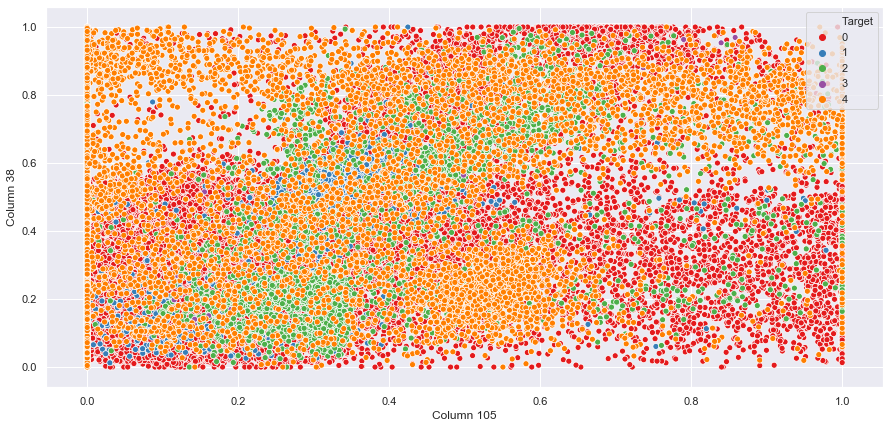

In [5]:
random_plotter(df_train)

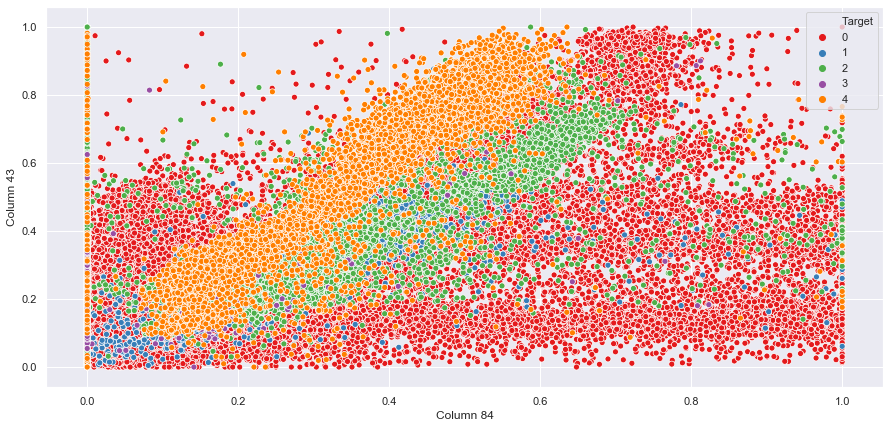

In [6]:
random_plotter(df_train)

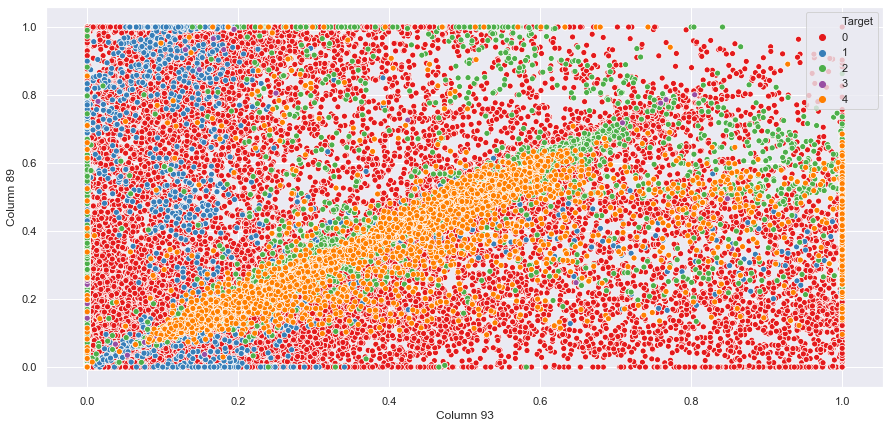

In [7]:
random_plotter(df_train)

You can see from the above plots that there clearly is a tendency for similar targets to group together. The grouping is not perfect in two dimensions however, in multiple dimensional space, they probably form more distinct clusters naturally.

This is why I believe a K Nearest Neighbors classifier would do well in this problem.

## Modelling

### Dimensionality Reduction (using Principal Component Analysis)

K Nearest Neighbors can be a computationally expensive algorithm when the number of feature is very high. In our case we have 187 features which can make the model take a long time to run. 

Since, interpretability of the data is not as important as in our case - we only need to classify, and do not really need to identify any insights from the data,  and also the data is not very human interpretable to begin with - PCA would be suitable to reduce the dimensionality of the dataset.

Let's not set this up and run it. Starting with separating the target from the dataset.

In [8]:
X_train = df_train.drop(columns = 187)
y_train = df_train[187]
X_test = df_test.drop(columns = 187)
y_test = df_test[187]

Let's first create a plot of the number of features vs the explained variance ratio.

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(187, random_state=42)
pca.fit(X_train)

var_ratio = pca.explained_variance_ratio_.cumsum()

print('Percentage Explained:', pca.explained_variance_ratio_.sum())

Percentage Explained: 1.0


In [11]:
from my_utils import explained_variance_ratio_plot

90% Information explained at 22 features.


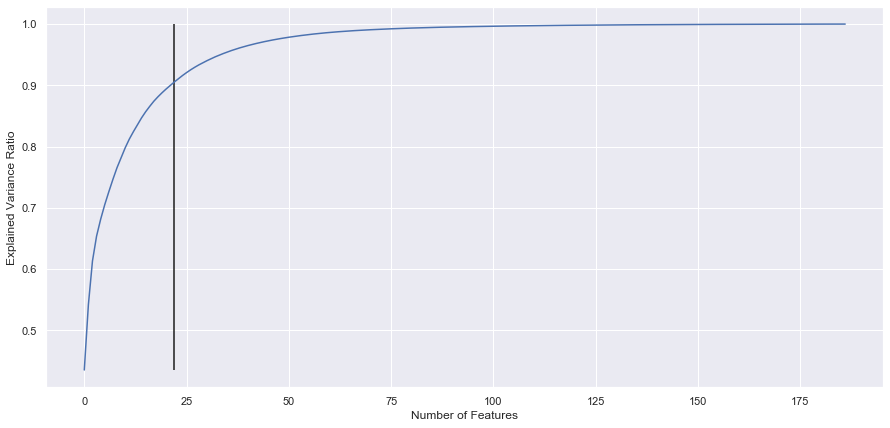

In [12]:
explained_variance_ratio_plot(var_ratio)

From the above plot we can see that 90% of the information can be explained by using just 22 features. Let's use 25 features for our model, and then transform our training and test datasets.

In [13]:
pca = PCA(25, random_state=42)
pca.fit(X_train)

var_ratio = pca.explained_variance_ratio_.cumsum()

print('Percentage Explained:', pca.explained_variance_ratio_.sum())

Percentage Explained: 0.9159206584461008


In [14]:
transformed_train = pca.transform(X_train)

print(transformed_train.shape)

(87553, 25)


In [15]:
transformed_test = pca.transform(X_test)

print(transformed_test.shape)

(21891, 25)


In [16]:
pd.DataFrame(transformed_train).head()

0         1         2         3         4         5         6   \
0 -1.436901  0.604471 -0.569385 -0.413983 -0.194281 -0.380065  0.079087   
1 -1.720589 -0.075125 -0.245867  0.075484 -0.677723 -0.350698  0.206940   
2 -1.509371 -0.044757  0.349776  0.618407 -0.234000 -0.616878  0.102789   
3 -1.181027  1.019874 -0.778778 -0.607433 -0.055793 -0.127349  0.542454   
4  1.629008 -0.054743  1.132460  0.074607  0.041044 -0.350010 -0.400457   

         7         8         9   ...        15        16        17        18  \
0 -0.016607 -0.157498 -0.499978  ...  0.604310  0.042015  0.363352  0.213412   
1 -0.363518  0.383402 -0.029956  ...  0.019714  0.036887  0.274289  0.062900   
2 -0.205001  0.893539  0.132884  ...  0.090514  0.031356  0.195911 -0.131215   
3 -0.036783  0.053427 -0.575773  ...  0.554459  0.183420  0.271936  0.380356   
4 -0.220832 -0.151342 -0.773625  ... -0.065767 -0.155950  0.221666 -0.171608   

         19        20        21        22        23        24  
0 -0.222659  0.057785  0.023925 -0.107342  0.382880 -0.015210  
1 -0.409328 -0.122727  0.154371  0.087219  0.063205 -0.154955  
2 -0.158754 -0.401689 -0.036918 -0.055715  0.044029 -0.101039  
3 -0.030875  0.013224 -0.117121 -0.018827  0.335458  0.371201  
4 -0.108898  0.082249 -0.165231  0.227042 -0.350059 -0.059585  

[5 rows x 25 columns]

The DataFrames now only have 25 features in them, compared to 187 previously. This massively reduces the complexity of running a KNearest Neighbors Classifier on the dataset. 



## K Nearest Neighbors Classifier

Let's now set up and run the classifier. The model is trained on the training set, and predictions are made for both the training and test sets to check if there is any overfitting occuring. A cross validated score is also produced.

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, n_jobs = -1)

In [18]:
knn.fit(transformed_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [19]:
from sklearn.model_selection import cross_val_score

In [20]:
cross_val_score(knn, transformed_train, y_train, cv = 5, n_jobs = -1, scoring = 'f1_weighted').mean()

0.9751746351459696

It does pretty well. The weighted f1 score was used for cross validation to account for the imbalance of classes within the dataset. Most of the dataset consists of normal hearbeats, as compared to the abnormal ones.

Now lets try and obtain the metrics on the complete train and test sets. We are going to check the Accuracy Score and F1 Score for both datasets.

In [21]:
train_preds = knn.predict(transformed_train)
test_preds = knn.predict(transformed_test)

In [22]:
from my_utils import print_metric_results

In [23]:
print_metric_results(y_train , y_test, train_preds, test_preds)

Train Accuracy: 0.9859171016412915
Train F1 Score: 0.9856042200105037
Test Accuracy: 0.975606413594628
Test F1 Score: 0.9748362526952342


It does extremely pretty well. In fact it actually does better than using neural networks as shown in the examples on Kaggle. Here are a couple confusion matrices for both the training and test datasets.

In [24]:
from sklearn.metrics import confusion_matrix
from my_utils import plot_confusion_matrix

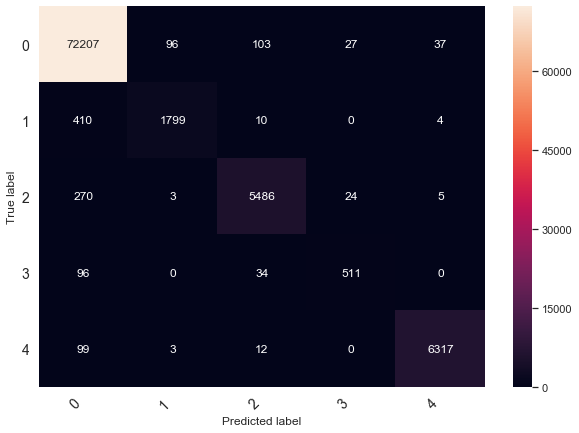

In [25]:
plot_confusion_matrix(confusion_matrix(y_train, train_preds), np.arange(5))

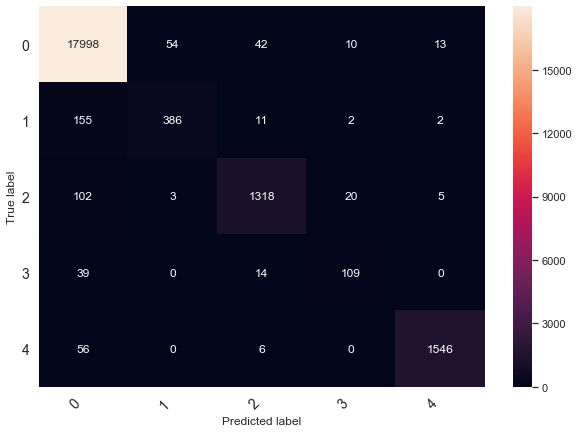

In [26]:
plot_confusion_matrix(confusion_matrix(y_test, test_preds), np.arange(5))

Let's also try and do this with the normal and abnormal heartbeat datasets to see how our model performs. In fact we could try and predict what class the abnormal examples are in df_abnormal. We can later plot and verify these to see if our models predictions are plausible.

In [27]:
X_abnormal = df_abnormal.drop(columns = 187)
X_normal = df_normal.drop(columns = 187)

In [28]:
df_abnormal_transformed = pca.transform(X_abnormal)
df_normal_transformed = pca.transform(X_normal)

In [29]:
abnormal_preds = knn.predict(df_abnormal_transformed)
normal_preds = knn.predict(df_normal_transformed)

In [30]:
pd.Series(abnormal_preds).value_counts()

0.0    9392
2.0     452
1.0     386
4.0     256
3.0      19
dtype: int64

All the data in this dataset was labelled as abnormal, however the class of abnormality was not labelled. 

Our model does not perform as expected here. This could be likely because there were only 4 types of Cardiac Arrythmia in our previous datasets, however this dataset may have additional types of abnormal heartbeats. The model may be classifying anything that is not the labelled 4 types of Arrythmia as normal. We may be able to visualize this later.

In [31]:
pd.Series(normal_preds).value_counts()

0.0    3898
1.0     115
2.0      31
4.0       1
dtype: int64

For the normal dataset, the model performs as expected. It does classify a small subset of the data as abnormal, but this could be mislabled data or just some error. Even if some of them are errors, the model mostly does well. We could visualize these results later to confirm. 

Now let's concatenate these results to the end of the respective DataFrames and then plot them by target.

In [32]:
df_abnormal_predicted = df_abnormal.copy()
df_normal_predicted = df_normal.copy()

In [33]:
df_abnormal[187] = pd.Series(abnormal_preds)
df_normal[187] = pd.Series(normal_preds)

Plotting df_abnormal first by target.

In [34]:
from my_utils import plot_series

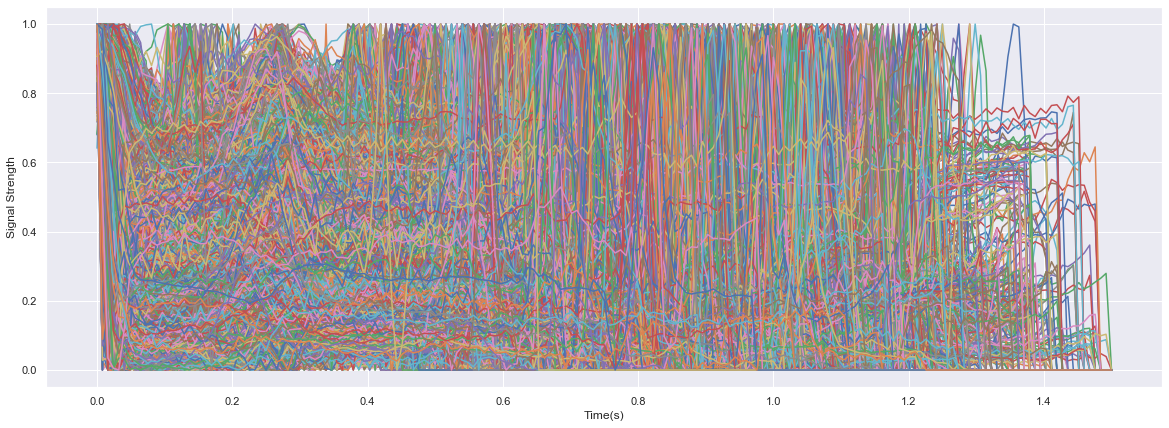

In [35]:
plot_series(df_abnormal[df_abnormal[187] == 0].iloc[:, :-1])

As you can see the plots looks a lot messier than our normal plot from the training set. This is a sign that these are abnormal heartbeats that were not in the training set which the model incorrectly classifies as normal.

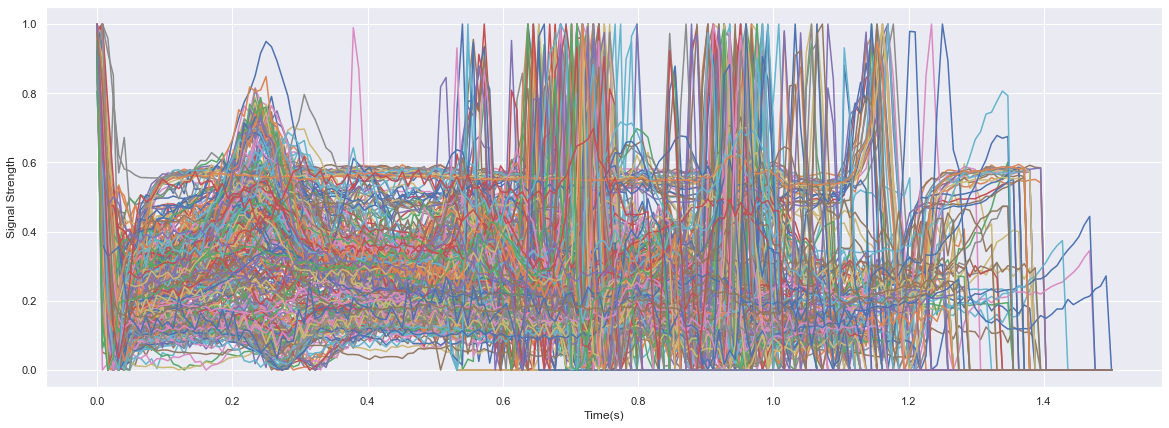

In [36]:
plot_series(df_abnormal[df_abnormal[187] == 1].iloc[:, :-1])

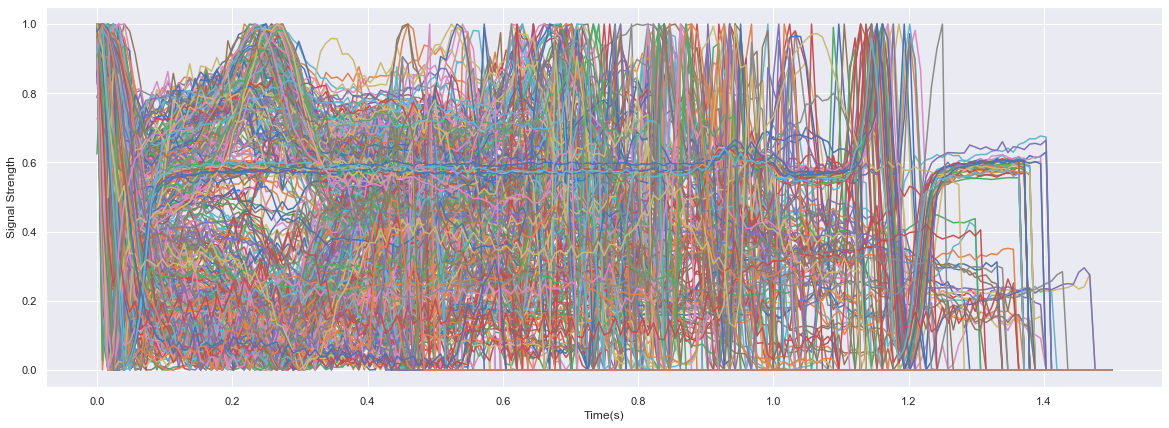

In [37]:
plot_series(df_abnormal[df_abnormal[187] == 2].iloc[:, :-1])

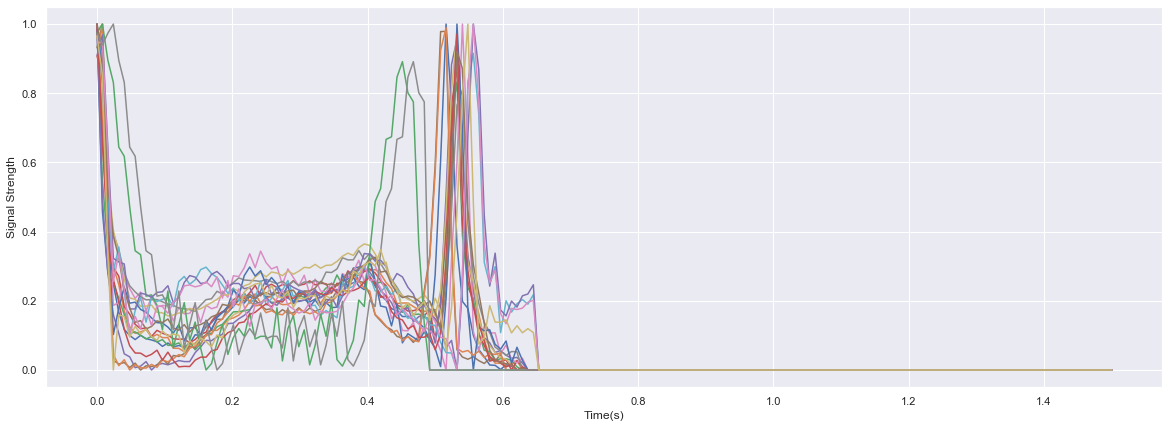

In [38]:
plot_series(df_abnormal[df_abnormal[187] == 3].iloc[:, :-1])

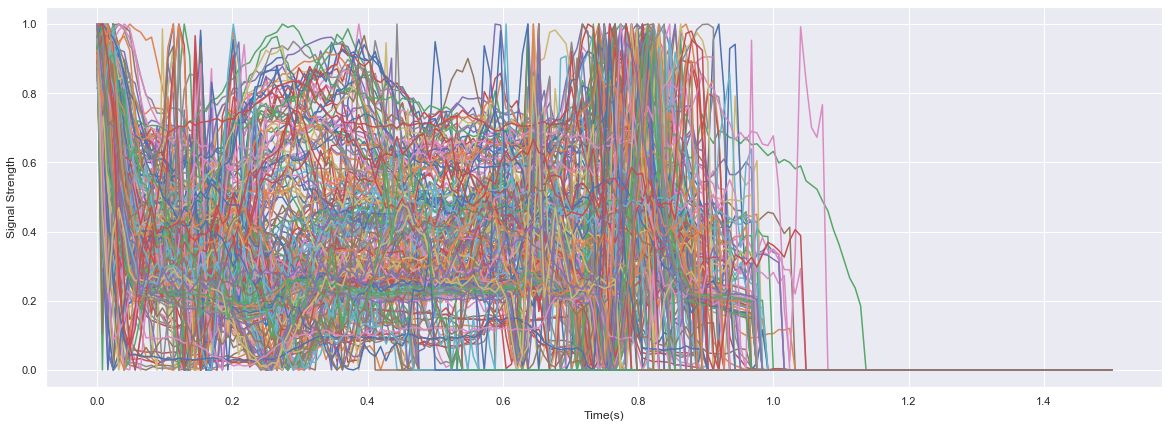

In [39]:
plot_series(df_abnormal[df_abnormal[187] == 4].iloc[:, :-1])

The above plots with labels 1 to 4 have a much more distinctly visible pattern, compared to the plot of 0 labels. The patterns are also similar to the patterns seen in the EDA Notebook when df_train was plotted by label. This indicates that these were among the types of arrythimia that the model was trained on.

Now lets try df_normal

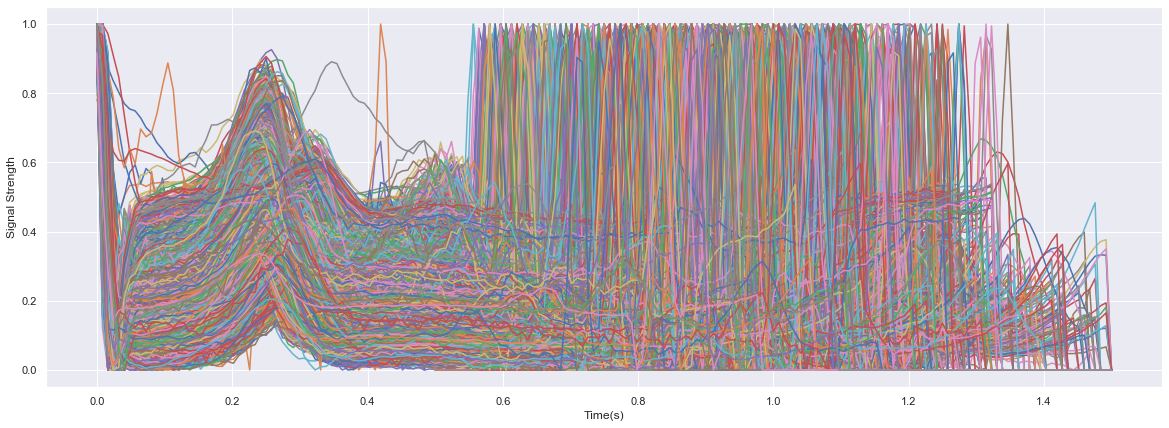

In [40]:
plot_series(df_normal[df_normal[187] == 0].iloc[:, :-1])

The plot looks very clean here, indicating that the model has correctly classified normal hearbeats.

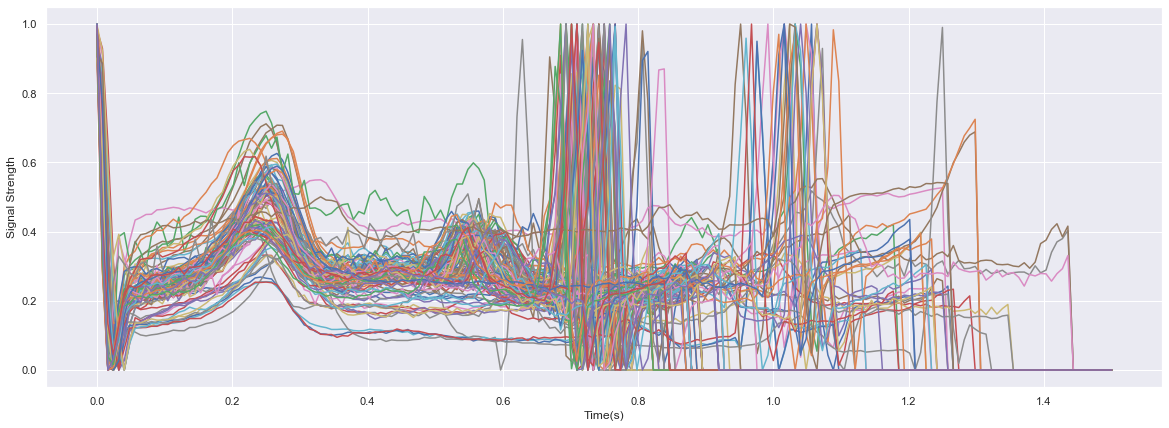

In [41]:
plot_series(df_normal[df_normal[187] == 1].iloc[:, :-1])

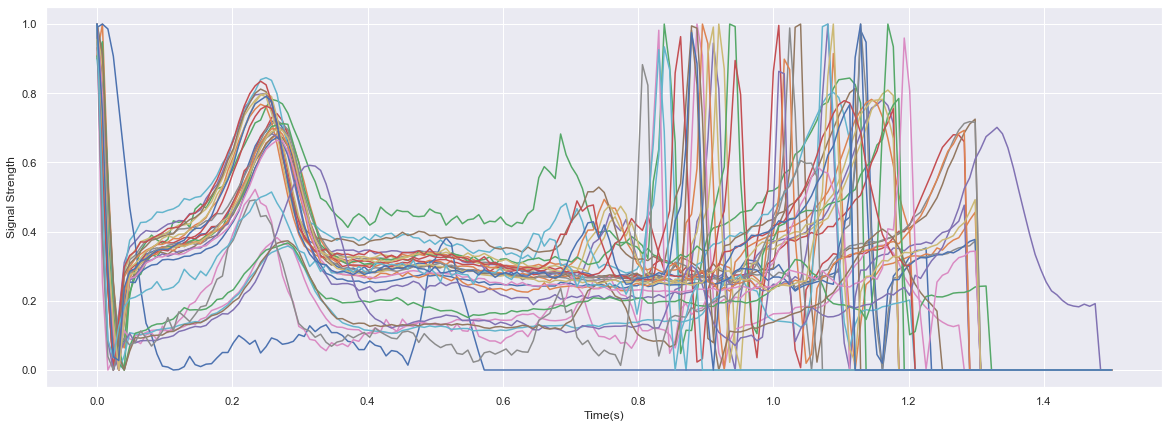

In [42]:
plot_series(df_normal[df_normal[187] == 2].iloc[:, :-1])

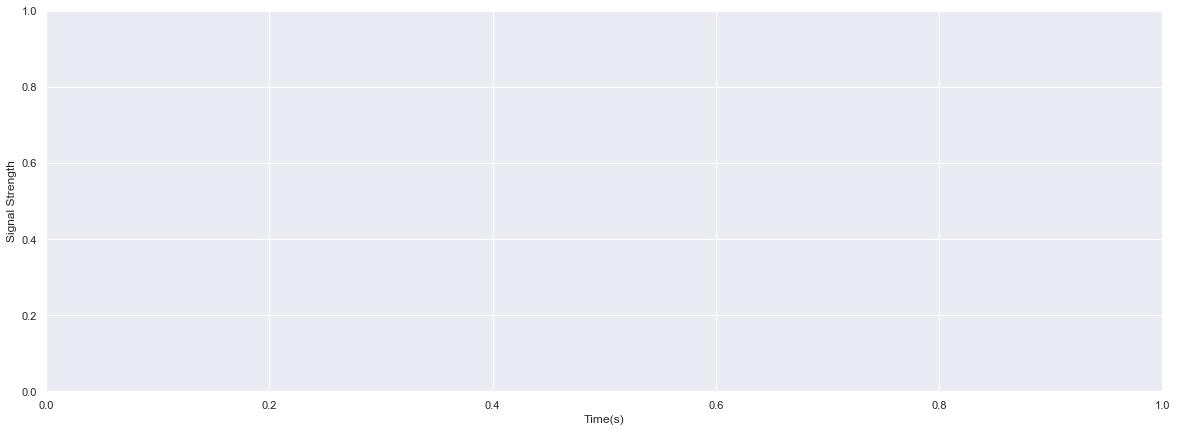

In [43]:
plot_series(df_normal[df_normal[187] == 3].iloc[:, :-1])

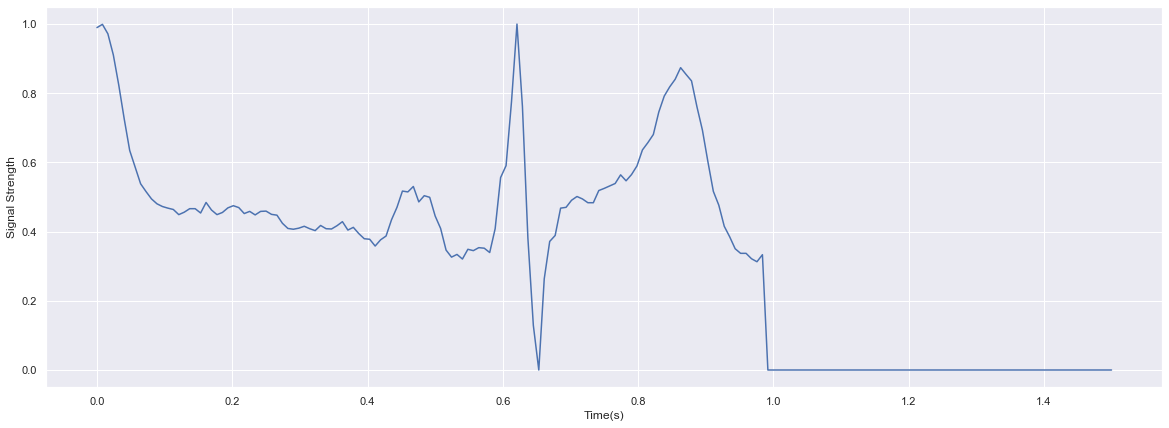

In [44]:
plot_series(df_normal[df_normal[187] == 4].iloc[:, :-1])

These rest of the plots also have distinct patterns, however they may be correctly or incorrectly classified. It does similar to the normal hearbeat pattern, however, I would not be able to tell, as I do not the expertise for that.

For our purposes, the number of samples that is classified incorrectly are just 147 out of a total of 4045, which is about 0.036% of the data. This is an extremely good result. 

We can conclude that at this stage our model can be used to classify normal and abnormal hearbeats extremely well, however more data is needed to allow our model to learn to classify the different classes of heartbeats, especially the ones that are not currently in our training set.

We will try the same with a binary classifier to see if we can get better resuts. But before that I am also going to try to use matrix profiling using Stumpy to see if it helps in picking up any additional patterns.